In [1]:
import argparse
import os.path as osp
import os
from collections import defaultdict

import mmcv
import torch
from mmcv import Config, DictAction
from mmcv.parallel import MMDataParallel
from mmcv.runner import init_dist, load_checkpoint

from mmcls.datasets import build_dataloader, build_dataset
from mmcls.models import build_classifier
from mmcv import tensor2imgs
import matplotlib.pyplot as plt
import numpy as np


In [2]:
config_file = 'configs/imagenet/resnet50_batch256.py'
checkpoint_file = 'resnet50.pth'


In [3]:
hidden_outputs = {}


def activation_hook(name):
    def hook(module, input, output):
        hidden_outputs[name] = output

    return hook


def register_activation_hook(model):
    for module_name, module in model.module.named_modules():
        if 'layer4' in module_name and 'relu' in module_name:
            module.register_forward_hook(activation_hook(module_name))
            print(f'{module_name} is registered')


activations = dict()


def single_gpu_vis(model,
                   data_loader,
                   show=False,
                   out_dir=None):
    model.eval()
    register_activation_hook(model)

    dataset = data_loader.dataset
    prog_bar = mmcv.ProgressBar(len(dataset))
    for i, data in enumerate(data_loader):
        batch_size = data['img'].size(0)
        with torch.no_grad():
            model(return_loss=True, **data)

        gt_label = data['gt_label'].cuda()

        for name in hidden_outputs:
            hidden_output = hidden_outputs[name].view(batch_size, -1)
            if name not in activations:
                activations[name] = hidden_output.new_zeros(
                    1000, hidden_output.shape[-1])
            activations[name].scatter_add_(0, gt_label.unsqueeze(
                1).expand_as(hidden_output), hidden_output)
            activations[name] = activations[name]

        hidden_outputs.clear()

        for _ in range(batch_size):
            prog_bar.update()

In [4]:
cfg = Config.fromfile(config_file)
# set cudnn_benchmark
if cfg.get('cudnn_benchmark', False):
    torch.backends.cudnn.benchmark = True
cfg.model.pretrained = None
cfg.data.test.test_mode = True

# init distributed env first, since logger depends on the dist info.
distributed = False

# build the dataloader
dataset = build_dataset(cfg.data.test)
data_loader = build_dataloader(
    dataset,
    samples_per_gpu=cfg.data.samples_per_gpu,
    workers_per_gpu=cfg.data.workers_per_gpu,
    dist=distributed,
    shuffle=False,
    round_up=False)


# build the model and load checkpoint
model = build_classifier(cfg.model)
checkpoint = load_checkpoint(model, checkpoint_file, map_location='cpu')
# old versions did not save class info in checkpoints, this walkaround is
# for backward compatibility
if 'CLASSES' in checkpoint['meta']:
    model.CLASSES = checkpoint['meta']['CLASSES']
else:
    model.CLASSES = dataset.CLASSES

assert not distributed
model = MMDataParallel(model, device_ids=[0])


In [5]:
single_gpu_vis(model, data_loader, True)

backbone.layer4.0.relu is registered
backbone.layer4.1.relu is registered
backbone.layer4.2.relu is registered
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 50000/50000, 339.2 task/s, elapsed: 147s, ETA:     0s

TypeError: If only one positional argument given, it must  be a Cycler instance.

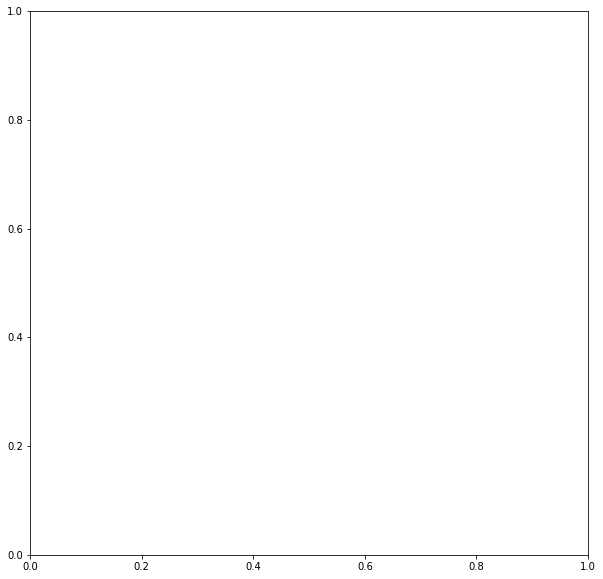

In [6]:
result = {}
for name in activations:
    layer_act = activations[name]

    num_class, num_neuron = layer_act.size()
    dead_neuron_class = torch.tensor(num_class)
    dead_neuron_confidence = torch.tensor(0.)

    selected_class = []
    selectivity_index = []
    for neuron_idx in range(num_neuron):
        neuron_act = layer_act[:, neuron_idx]

        # In the case of mean activations of a neuron are all zero across whole classes
        # Simply consider that neuron as dead neuron.
        if neuron_act.nonzero().size(0) == 0:
            class_selected = dead_neuron_class
            class_confidence = dead_neuron_confidence
        else:
            class_selected = neuron_act.argmax()
            mu_max = neuron_act[class_selected]
            mu_mmax = (neuron_act.sum() - mu_max).div(num_class - 1)
            class_confidence = (mu_max - mu_mmax).div(mu_max + mu_mmax)

        selected_class.append(class_selected)
        selectivity_index.append(class_confidence)

    selected_class = torch.stack(selected_class, 0)
    selectivity_index = torch.stack(selectivity_index, 0)

    result[name] = dict()
    result[name]['selected_class'] = selected_class.cpu().numpy()
    result[name]['selectivity_index'] = selectivity_index.cpu().numpy()



/mnt/xujiarui/miniconda/envs/open-mmlab/lib/python3.7/site-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  # This is added back by InteractiveShellApp.init_path()
/mnt/xujiarui/miniconda/envs/open-mmlab/lib/python3.7/site-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  # This is added back by InteractiveShellApp.init_path()


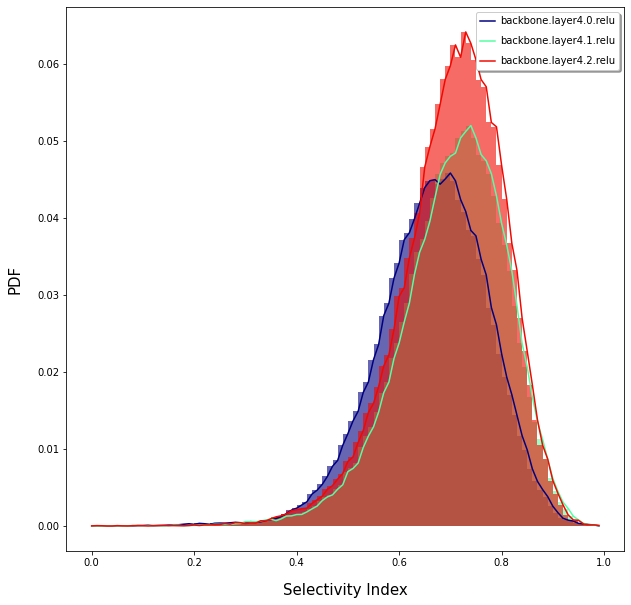

In [7]:
num_plots = len(result)
colormap = plt.cm.jet
plt.figure(figsize=(10, 10))
plt.gca().set_prop_cycle(color=
    [colormap(i) for i in np.linspace(0, 0.9, num_plots)])

labels = []
for name in result:
    selectivity_index = result[name]['selectivity_index']
    selectivity_index_hist = np.histogram(selectivity_index * 100,
                                          bins=100, normed=True)
    x = np.arange(len(selectivity_index_hist[0])) / len(
        selectivity_index_hist[0])
    y = selectivity_index_hist[0]
    plt.fill_between(x, y, step="pre", alpha=0.6)
    plt.plot(x, y)
    labels.append(name)

plt.legend(labels, ncol=1, loc='upper right',
           columnspacing=2.0, labelspacing=1,
           handletextpad=0.5, handlelength=1.5,
           fancybox=True, shadow=True)
plt.ylabel('PDF', fontsize=15, labelpad=15)
plt.xlabel('Selectivity Index', fontsize=15, labelpad=15)

# figname = os.path.join(out_dir, 'histogram.png')
# plt.savefig(figname)
plt.show()

In [8]:
mmcv.mkdir_or_exist('r50')
mmcv.dump(result, './r50/result.pkl')

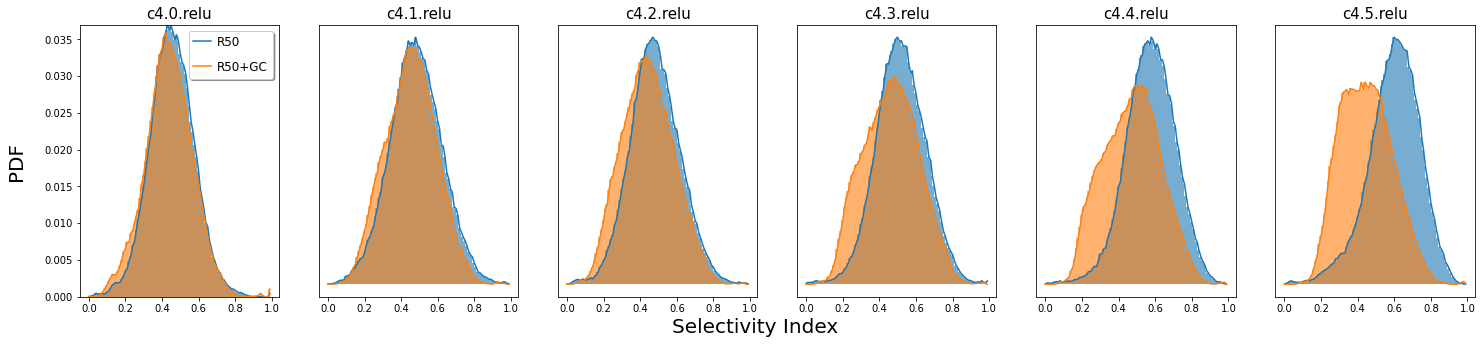

In [45]:
import warnings
warnings.filterwarnings('ignore')
file_paths = ['./output/r50_c3/result.pkl', './output/r50_gc-r4_c3/result.pkl']
results = [mmcv.load(f) for f in file_paths]
f = plt.figure(figsize=(25, 5))
f_i = 1
axes = []
max_y = 0
for name in results[0]:
    ax = f.add_subplot(1, len(results[0]), f_i)
    axes.append(ax)
    for result in results:
        selectivity_index = result[name]['selectivity_index']
        selectivity_index_hist = np.histogram(selectivity_index * 100,
                                          bins=100, normed=True)
        x = np.arange(len(selectivity_index_hist[0])) / len(
            selectivity_index_hist[0])
        y = selectivity_index_hist[0]
        max_y = max(y.max(), max_y)
        plt.fill_between(x, y, step="pre", alpha=0.6)
        plt.plot(x, y)
    
    if f_i == 1:
        plt.legend(['R50', 'R50+GC'], ncol=1, loc='upper right',
                   columnspacing=2.0, labelspacing=1,
                   handletextpad=0.5, handlelength=1.5,
                   fancybox=True, shadow=True, fontsize=12)
    name_splits = name.split('.')
    plt.title('c'+str(int(name_splits[1][-1])+1)+'.'+'.'.join(name_splits[2:]), fontsize=15)
    f_i +=1
# axes[0].ylabel('PDF', fontsize=15, labelpad=15)
# plt.xlabel('Selectivity Index', fontsize=15, labelpad=15)
# Set common labels
axes[0].set_ylim(0, max_y)
for i in range(1, len(axes)):
#     axes[i].get_xaxis().set_ticks([])
    axes[i].get_yaxis().set_ticks([])
f.text(0.09, 0.5, 'PDF', ha='center', va='center', rotation='vertical', fontsize=20)
f.text(0.5, 0.04, 'Selectivity Index', ha='center', va='center', fontsize=20)
mmcv.mkdir_or_exist('output/r50_gc-r4_c3/vis/')
plt.savefig(f'./output/r50_gc-r4_c3/vis/merged.png', bbox_inches='tight')
plt.show()